# Self-Driving Car Engineer Nanodegree
## Deep Learning
## Project: Vehicle Detection and Tracking
**Author:** Bryan Rosales

**Date:** August 24 2017

My project includes the following files:
* P5.ipynb containing the script to process the images and the vehicle detection
* WriteUp P5.html which is this file reporting the project pipeline and explanations
* (Folder output_video )project_video.mp4 containing the video with the vehicle detection
* (Folder: output_images) test images. For example:
   - test1_detection.jpg. Final result with detection rectangle.
   - test1_search.jpg. First search for cars.
   - test1_research0.jpg. Second search around the car detected.
   - test1_headmap1.jpg and test1_headmap2.jpg. Headmap for each search.

## Pipeline Description
The pipeline proposed to the solution consisted of 4 steps:
 1. Feature Extraction
 2. Training the Classifier
 3. Vehicle Detection
 4. Video Generation

## Loading Images Paths

Before start the feature extraction phase, my script must load the images paths provided in the cars and non-cars datasets. The dataset contains 17.760 images with 8792 cars images and 8968 non-cars images. 

Note that the dataset is very well balanced in the number of images for each class. Finally a sample image is displayed. 

Something important is that the every image is read with cv2.imread (BGR) but inmediatelly converted to RGB using cvtColor. The pipeline used RGB images as a input in all the proccess; however, the feature extraction is  using YUV color map.

Non-Cars:  8968 
Cars:  8792 
Total Images:  17760


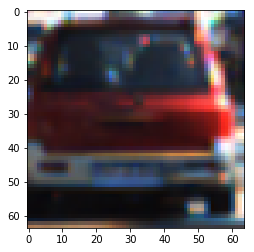

In [3]:
cars = glob.glob('dataSet/vehicles/*/*.png')
notcars = glob.glob('dataSet/non-vehicles/*/*.png')

print('Non-Cars: ', len(notcars), '\nCars: ',len(cars),'\nTotal Images: ', len(cars)+len(notcars))

# Sample Image in the Dataset
imgSample = cv2.imread(cars[6350])
imgSample = cv2.cvtColor(imgSample, cv2.COLOR_BGR2RGB)
plt.title = 'Car'
plt.imshow(imgSample)

## 1. Features Extraction

In this step, I define the class Parameters to manage the tunning parameters to features extraction functions, classifier, scaler and camera undistortion.

The script extracts 3 types of features:
* Spatial Bin
* Colors Histogram
* HOG (Histogram Oriented Gradients)

The overall of features is 2580 by image.
All the image are read to be in scale 0 to 255, which will be normalized between 0 and 1 in the next phases.

For the Spatial Bin features, My code resizes the image to 16x16 and create a flat feature vector of 256 x 3 = 768 for each image.

For Colors Histogram technique, I am using bins of 16 and extracting the histogram values for each channels of YUV format. (16 x 3 = 48)

In addition, the gradients are extracted using HOG skimage function. I defined orientation = 9, pixel per cell = 8, cells per block = 2 and hog channel = 1. After several try and error, the channel 1 'U' presented a good performance to extract HOG gradients and classify images correctly. 
The size of the HOG feature vector is 1764.

With the previous 3 types of features, I will fit a classifier to detect vehicles in the project video.

In [4]:
class Parameters:
    
    def __init__(self, colorSpace, orient,pixperCell,
                 cellperBlock,hogChannel,spatialSize,
                 histBins,spatialFeat,histFeat,hogFeat,classifier,scaler,mtx,dist):
        # Parameter Definition
        self.colorSpace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.spatialSize = (16, 16) # Spatial binning dimensions
        self.histBins = 16    # Number of histogram bins        
        self.orient = 9  # HOG orientations
        self.pixperCell = 8 # HOG pixels per cell
        self.cellperBlock = 2 # HOG cells per block
        self.hogChannel = 0 # Can be 0, 1, 2, or "ALL"        
        self.spatialFeat = True # Spatial features on or off
        self.histFeat = True # Histogram features on or off
        self.hogFeat = True # HOG features on or off
        self.classifier= None #SVM Classifier
        self.scaler = None #Scaler to Normalize the data
        self.mtx = None #Camera Calibration Matrix
        self.dist = None #Camera Calibration 

   

# Parameter Definition
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 1 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# Instance of Parameters
if __name__ == '__main__':
    p = Parameters(color_space,orient,pix_per_cell,cell_per_block,
                   hog_channel,spatial_size,hist_bins,spatial_feat,
                   hist_feat,hog_feat,None,None,None,None)

In [5]:
# the function calls each function to extract color_hist, Hog_hist and Binning Colors
carsFeatures = extract_features(cars,color_space= p.colorSpace, spatial_size= p.spatialSize,
                                hist_bins= p.histBins,orient= p.orient,
                                pix_per_cell= p.pixperCell,cell_per_block= p.cellperBlock,
                                hog_channel= p.hogChannel,spatial_feat= p.spatialFeat, 
                                hist_feat= p.histFeat, hog_feat= p.hogFeat)

notcarsFeatures = extract_features(notcars,color_space= p.colorSpace, spatial_size= p.spatialSize,
                                   hist_bins= p.histBins,orient= p.orient,
                                   pix_per_cell= p.pixperCell,cell_per_block= p.cellperBlock, 
                                   hog_channel= p.hogChannel,spatial_feat= p.spatialFeat, 
                                   hist_feat= p.histFeat, hog_feat= p.hogFeat)
print('Done...')

/home/spider/anaconda3/envs/udacity/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Done...


### Data Preprocessing

Here, I merge the features for cars and not cars in 'X' and also the labels in 'y' vector with 1s for cars and 0s for not cars are created. The total of images is 17760 and 2580 features by image.

In [6]:
# Array of Cars and Not Cars Features
X = np.vstack((carsFeatures, notcarsFeatures)).astype(np.float64)                        

# Array of Labels to Cars and Not Cars
y = np.hstack((np.ones(len(carsFeatures)), np.zeros(len(notcarsFeatures))))
print('Features Shape: ',X.shape,'\nLabels Shape: ',y.shape)

Features Shape:  (17760, 2580) 
Labels Shape:  (17760,)


Next, the feature vector is scaled between 0 and 1 for training a SVC. Then, the data is splitted 80% for training and 20% for testing.

In [8]:
# Scaling X vector of features
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
# Allocate the scaler to the Parameter instance
p.scaler = X_scaler

# Spliting randomly the Data
rand_state = np.random.randint(0, 100)
Xtrain, Xtest, ytrain, ytest = train_test_split(scaled_X,y,test_size=0.2,random_state=42)
print('Xtrain: ',Xtrain.shape,' ytrain: ',ytrain.shape,'\nXtest: ',Xtest.shape,' ytest:',ytest.shape)

Xtrain:  (14208, 2580)  ytrain:  (14208,) 
Xtest:  (3552, 2580)  ytest: (3552,)


## 2. Training the Classifier

The algorithm selected as classifier is Support Vector Machine and Linear classifier using scikit learn library. The main reason is simplicity, computation cost, training speed and accuracy. Support Vector Machine manages efficiently the decision boundary and works very well in binary classification. Another option that can gives good result is neural net but it is more complex to implement and expensive computationally.

The Linear SVC was trained with different C penalties values, being C=0.001 the best result. The training time was only 2.98 seconds which is extremely fast.

The accuracy in the training set was 0.995 and testing was 0.985 which is a fantastic accuracy. Because the numbers, I can conclude that the model does not present overfitting.

### Fitting a SVM Classifier

In [9]:
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [10]:
t=time.time()
clf = LinearSVC(C=0.001, penalty='l2', loss='hinge', random_state=0)
clf.fit(Xtrain, ytrain)
t1 = time.time()
print('Training Time:',round(t1-t, 2),'Seconds')

# Allocate the classifier to the instance of Parameters
p.classifier = clf

Training Time: 2.78 Seconds


### Classifier Accuracy

In [11]:
print('Training Accuracy:',round(clf.score(Xtrain,ytrain), 4))
print('Testing Accuracy:',round(clf.score(Xtest,ytest), 4))

Training Accuracy: 0.9949
Testing Accuracy: 0.9854


## 3. Vehicle Detection

Before go in vehicle detection is important apply undistorting process to correct image curvature in the borders. So, I'm reading the calibration parameters calculated in previous project (Advanced Lane Line Detection) and applying undistoring to every frame processed.

In [12]:
file = 'calibration_params.p'
camera_parameters = readCameraparams(file)

# Allocate the Camera parameters to instance in Class Parameters
p.mtx = camera_parameters['mtx']
p.dist = camera_parameters['dist']
print('Done...')

Done...


To detect the vehicle and draw a rectangle for tracking was required the following steps contained in the function detectionPipeline():

1) I slided windows of 128x128 staring from (x=860,y=380) to (x=imageWidth,y=imageHeight) and overlaping 85% for both directions.

2) I slided windows of 48x48 staring from (x=575,y=1050) to (x=400,y=530) and overlaping 75% for both directions. 
The windows covered the interest lanes area.

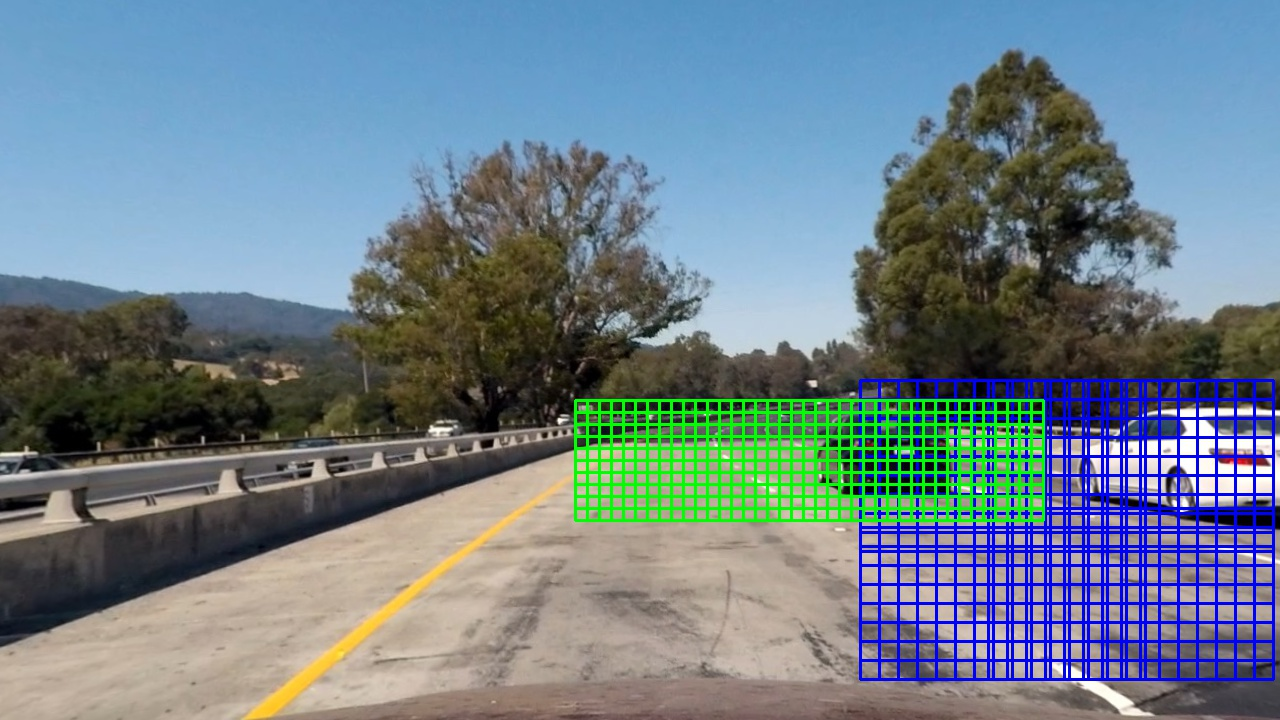

In [10]:
from IPython.display import HTML
from IPython.display import Image
Image(filename='DeliverableV1.0/output_images/test1_search.jpg')

3) My algorithm extracted every image for each window and calls for feature extraction function and classification. Thewheren, every image contained in a window was classified as car '1' or not car '0' returning the position (x,y) of possible cars detection.

4) Next, I built a heat map where was incremented by 1 each pixel inside the windows that detected a possible vehicle.

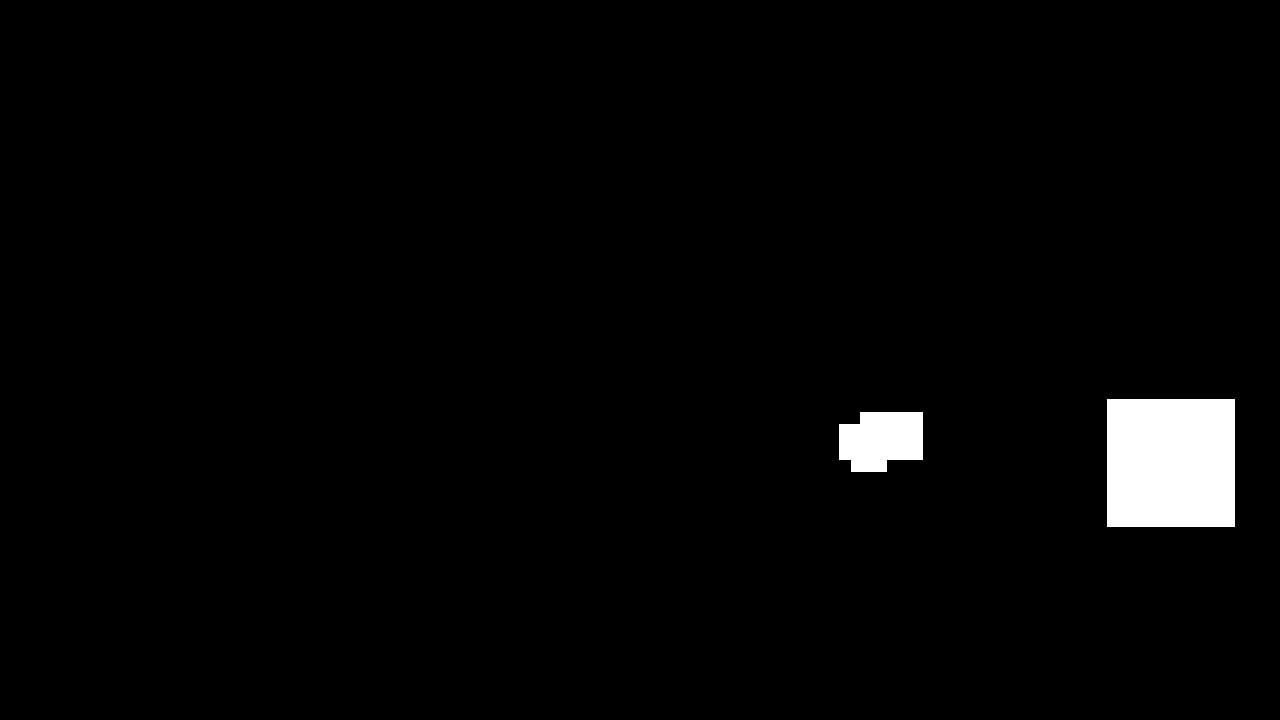

In [13]:
Image(filename='DeliverableV1.0/output_images/test1_heatmap1.jpg')

5) Where the algorithm detected vehicles or the same heat, I started over a new search with 64x64 size windows on neighbors pixels using a variable margin according to the y value. I used 30,40,50 for x pixels and 30,20 for y pixels. It was to increment accuracy of car detection. The new detections were added to the heat map.

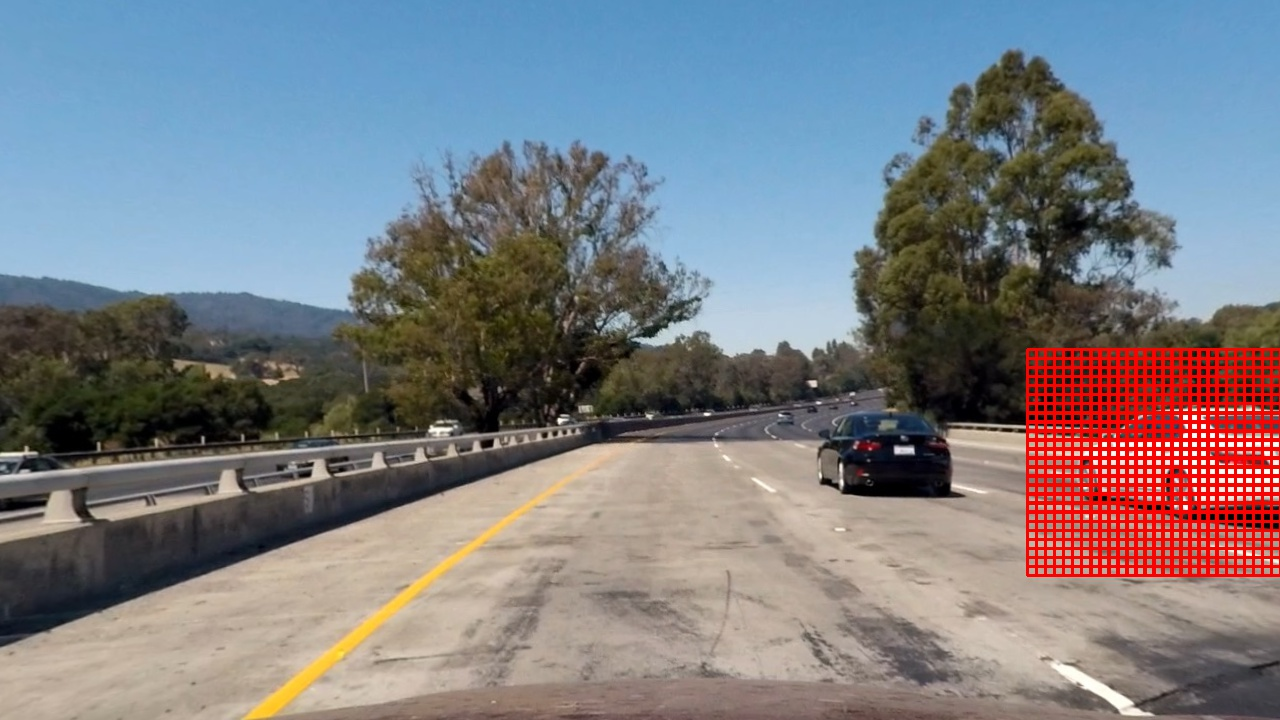

In [15]:
Image(filename='DeliverableV1.0/output_images/test1_research0.jpg')

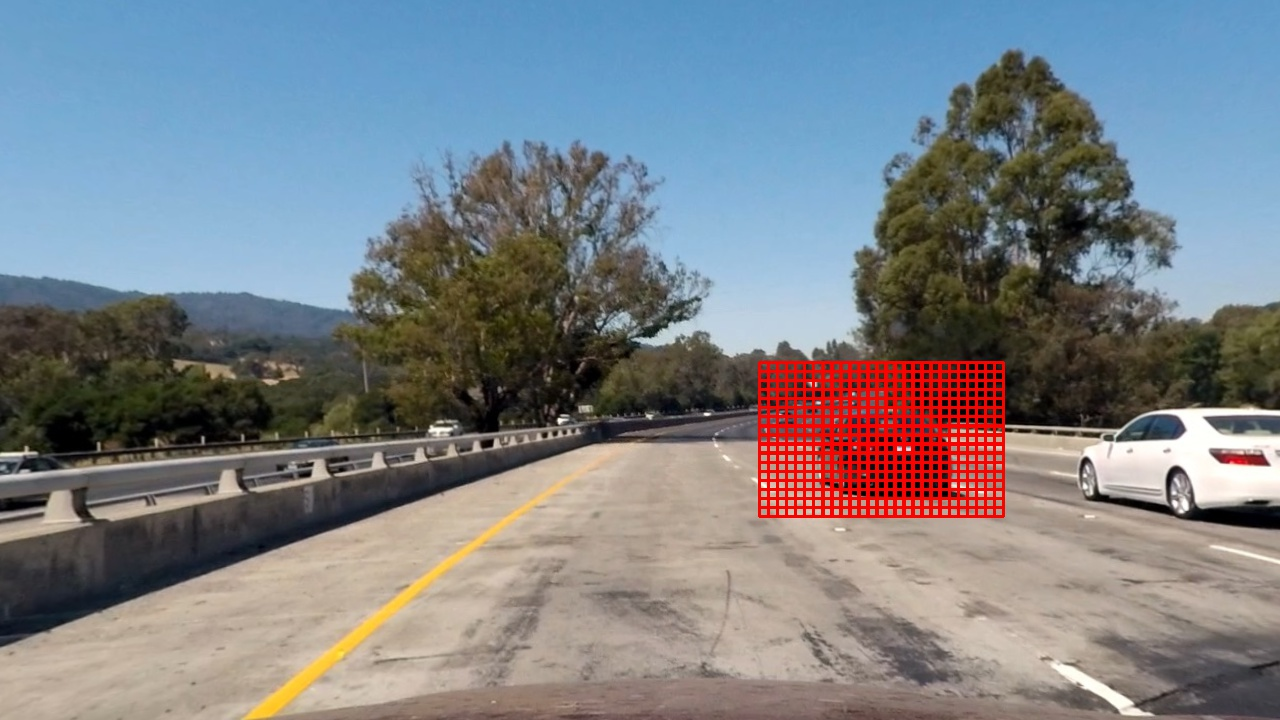

In [16]:
Image(filename='DeliverableV1.0/output_images/test1_research1.jpg')

6) I applied a threshold of 2 to the first heat map and 4 for the research. Then, it achieved to filter false detection and mantaining pixels with vehicles detected.

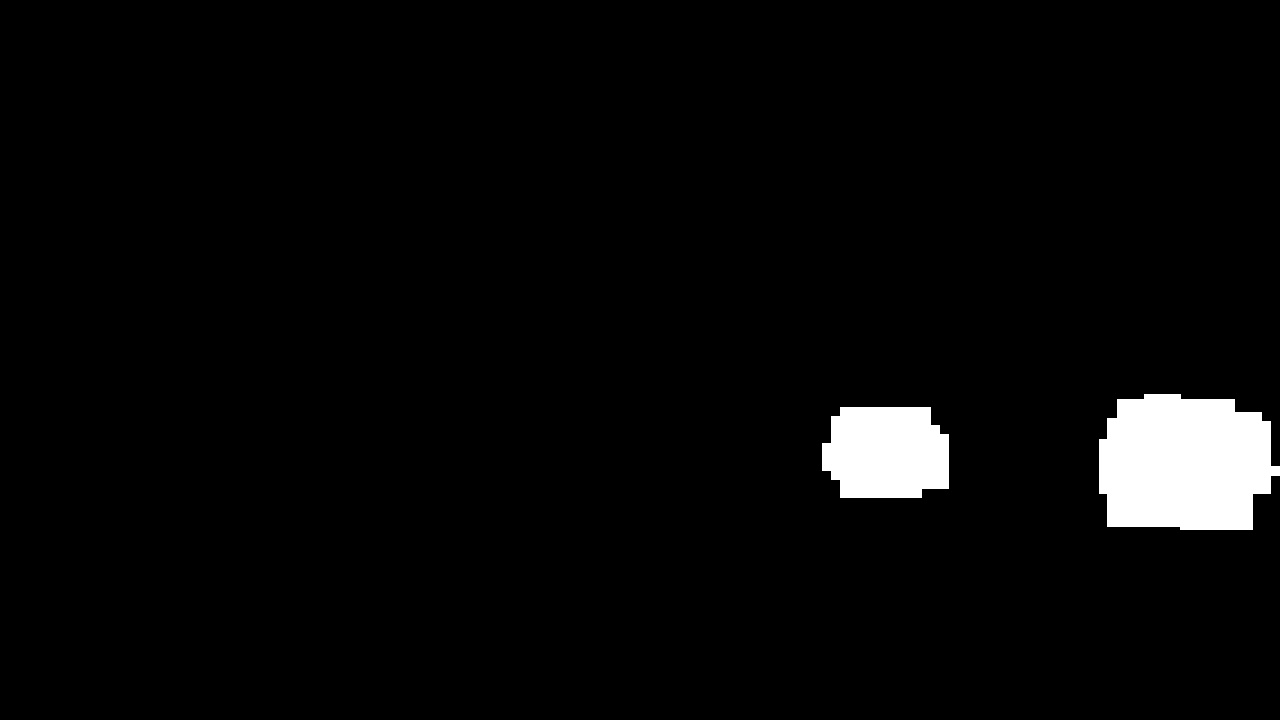

In [17]:
Image(filename='DeliverableV1.0/output_images/test1_heatmap2.jpg')

7) Finally, I used the scipy measurement to obtain the point of the rectangles covering pixels vehicle detections and then I drew the rectangles to track the cars on the original image.

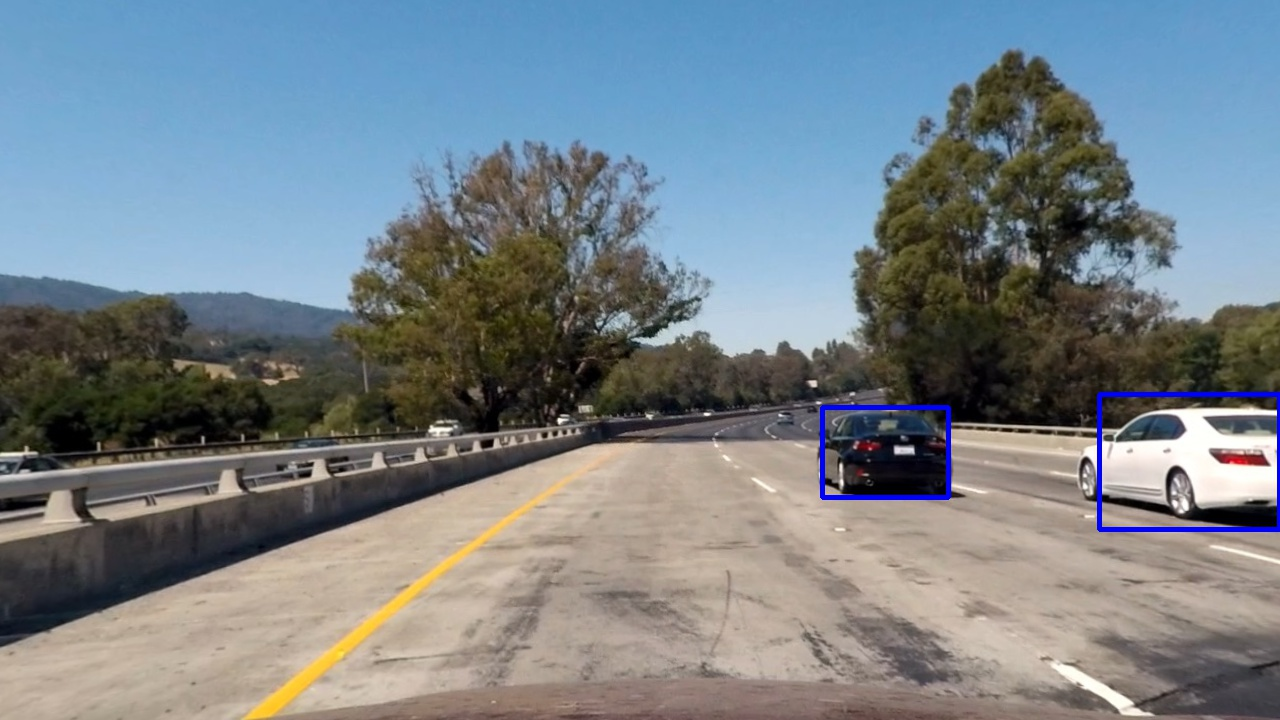

In [18]:
Image(filename='DeliverableV1.0/output_images/test1_detection.jpg')

## 4. Video Generation

To read frame by frame from the project video, I am using VideoFileClip. Then, every frame read is passed to a pipeline function to execute all the steps described previously.

In [19]:
HTML("""
    <video controls src="{0}" loop=1 autoplay width=100%/> 
    """.format('DeliverableV1.0/output_video/project_video.mp4')
)

### Finals Comments

1. The algorithm could be improved to draw smooth rectangles on detected vehicle saving the last rectangle position and computing an average. Even though it does not affect the efficiency of the algorithm, it makes a better visualization in the video.

2. In the video, when the vehicle passes the big traffic sign color green with letters white, my algorithm detect the sign as a vehicle and extends the rectangle zone. It could be improved using more channels in the HOG. However, the false detection does not affect the car and passenger security.

3. The windows scan could be improved developing a more adaptative size of windows and overlaping. It can help to reduce computational time and more accuracy in the detection.

So far, this project has been amazing and also the term1 as well. I'm so glad studying this program and very grateful with you guys.

!!God Bless Udacity team.